In [1]:
using QuantumOptics
using IonSim
import PyPlot
const plt = PyPlot;

In [2]:
# set some plot configs
plt.matplotlib.rc("xtick", top=false)
plt.matplotlib.rc("ytick", right=false, left=false)
plt.matplotlib.rc("axes", labelsize=20, titlesize=20, grid=true)
plt.matplotlib.rc("axes", linewidth=2)
plt.matplotlib.rc("grid", alpha=0.25, linestyle="--")
plt.matplotlib.rc("font", family="Palatino", weight="medium")
plt.matplotlib.rc("figure", figsize=(8,4))
plt.matplotlib.rc("xtick.major", width=2)
plt.matplotlib.rc("ytick.major", width=2)

In [3]:
C = Ca40(["S-1/2", "D-1/2"])
L1 = Laser(pointing=[(1, 1.), (2, 1.)])
L2 = Laser(pointing=[(1, 1.), (2, 1.)])
chain = LinearChain(
        ions=[C, C], com_frequencies=(x=3e6,y=3e6,z=1e6), 
        vibrational_modes=(x=[1], z=[1])
    )
T = Trap(configuration=chain, B=6e-4, Bhat=(x̂ + ẑ)/√2, lasers=[L1, L2])

axial_mode = T.configuration.vibrational_modes.z[1]
radial_mode = T.configuration.vibrational_modes.x[1]

# Set Hilbert space dimension for participating vibrational modes
axial_mode.N = 5
radial_mode.N = 5;

┌ Warning: Some ions point to the same thing. Making copies.
└ @ IonSim /Users/josephbroz/.julia/packages/IonSim/fbKtL/src/ion_configurations.jl:160


In [4]:
Δf = transition_frequency(T, 1, ("S-1/2", "D-1/2"))
ϵ = 40e3

L1.Δ = Δf + axial_mode.ν + ϵ 
L1.k = ẑ
L1.ϵ = x̂

L2.Δ = Δf - axial_mode.ν - ϵ
L2.k = ẑ
L2.ϵ = x̂

η = abs(get_η(axial_mode, L1, C))
Ω = √(1e3 * ϵ) / η  # This will give a 1kHz MS strength, since coupling goes like (ηΩ)^2/ϵ

Efield_from_rabi_frequency!(Ω, T, 1, 1, ("S-1/2", "D-1/2"))
Efield_from_rabi_frequency!(Ω, T, 2, 1, ("S-1/2", "D-1/2"));

In [5]:
h = hamiltonian(T, lamb_dicke_order=1, rwa_cutoff=1e6);
@time tout, sol_res = timeevolution.schroedinger_dynamic(
        0:2:3000, C["D-1/2"] ⊗ C["S-1/2"] ⊗ axial_mode[0] ⊗ radial_mode[0], h
    );

 10.132951 seconds (46.49 M allocations: 2.219 GiB, 5.93% gc time)


In [6]:
h = hamiltonian(T, lamb_dicke_order=1, rwa_cutoff=1e6);

In [7]:
@time tout, sol_res = timeevolution.schroedinger_dynamic(
        0:2:3000, C["D-1/2"] ⊗ C["S-1/2"] ⊗ axial_mode[0] ⊗ radial_mode[0], h
    );

  0.412000 seconds (10.22 M allocations: 315.648 MiB, 13.73% gc time)


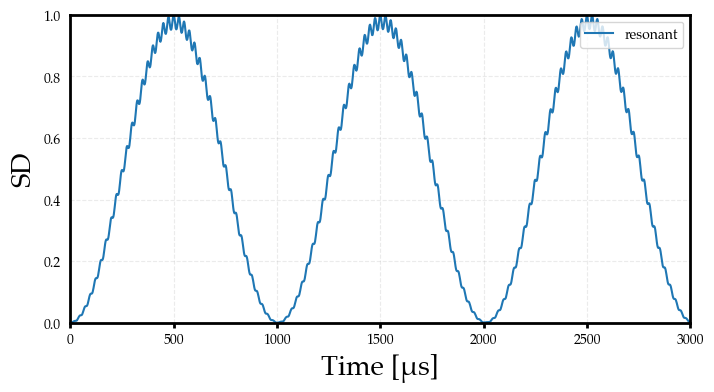

In [8]:
SD_res = expect(ionprojector(T, "S-1/2", "D-1/2"), sol_res)
step = 1
plt.plot(tout[1:step:end], SD_res[1:step:end], label="resonant")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.ylabel("SD")
plt.xlabel("Time [μs]");

In [9]:
# We'll add the barrier term by giving a nonzero value to the trap's B-field gradient:
set_gradient!(T, (1, 2), ("S-1/2", "D-1/2"), √5.25 * 1e3); 
# ΩMS = 1 kHz, so setting Δ = √5.25 kHz gives Ω' = √(ΩMS^2 + Δ^2) = 2.5 kHz

In [10]:
h = hamiltonian(T, lamb_dicke_order=1, rwa_cutoff=1e6);

In [11]:
@time tout, sol_det = timeevolution.schroedinger_dynamic(0:2:3000, 
    ionstate(T, "D-1/2", "S-1/2") ⊗ fockstate(axial_mode, 0) ⊗ fockstate(radial_mode, 0), h);

  0.459929 seconds (9.99 M allocations: 310.255 MiB, 15.18% gc time)


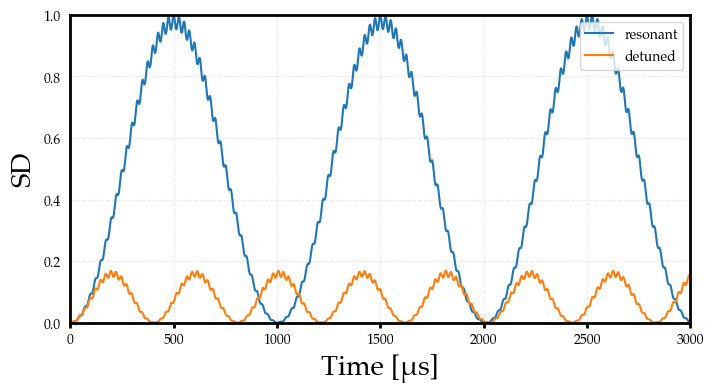

In [12]:
SD_det = expect(ionprojector(T, "S-1/2", "D-1/2"), sol_det)
step = 1
plt.plot(tout[1:step:end], SD_res[1:step:end], label="resonant")
plt.plot(tout[1:step:end], SD_det[1:step:end], label="detuned")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.ylabel("SD")
plt.xlabel("Time [μs]");

In [13]:
# setup two additional lasers for the S-B Hamiltonian
L3 = Laser(); L3.pointing = [(2, 1.0)]
L4 = Laser(); L4.pointing = [(2, 1.0)];

In [14]:
T.lasers = [L1, L2, L3, L4];

In [15]:
# Set the laser parameters
axial_mode = T.configuration.vibrational_modes.z[1]
radial_mode = T.configuration.vibrational_modes.x[1]

Δf = transition_frequency(T, 2, ("S-1/2", "D-1/2"))
νeff = √5.25 * 1e3

L3.Δ = Δf + radial_mode.ν / 2 + νeff  # We set the effective vibrational frequency by detuning the 2-photon transition off resonance
L3.k = x̂
L3.ϵ = ẑ

L4.Δ = Δf - radial_mode.ν / 2
L4.k = x̂
L4.ϵ = ẑ

η = abs(get_η(radial_mode, L3, C))
Ω = √((0.5e3 * radial_mode.ν) / η)  # Set κ = 0.5 kHz, since κ = ηΩ^2/ν

Efield_from_rabi_frequency!(Ω, T, 3, 2, ("S-1/2", "D-1/2"))
Efield_from_rabi_frequency!(Ω, T, 4, 2, ("S-1/2", "D-1/2"));

┌ Warning: !(ϵ ⟂ k)
└ @ IonSim /Users/josephbroz/.julia/packages/IonSim/fbKtL/src/lasers.jl:84
┌ Warning: !(ϵ ⟂ k)
└ @ IonSim /Users/josephbroz/.julia/packages/IonSim/fbKtL/src/lasers.jl:84


In [16]:
h = hamiltonian(T, lamb_dicke_order=1, rwa_cutoff=1.51e6);

In [17]:
@time tout, sol_vaet = timeevolution.schroedinger_dynamic(0:2:3000, 
    ionstate(T, "D-1/2", "S-1/2") ⊗ fockstate(axial_mode, 0) ⊗ fockstate(radial_mode, 0), h);

 40.546512 seconds (823.02 M allocations: 29.438 GiB, 13.07% gc time)


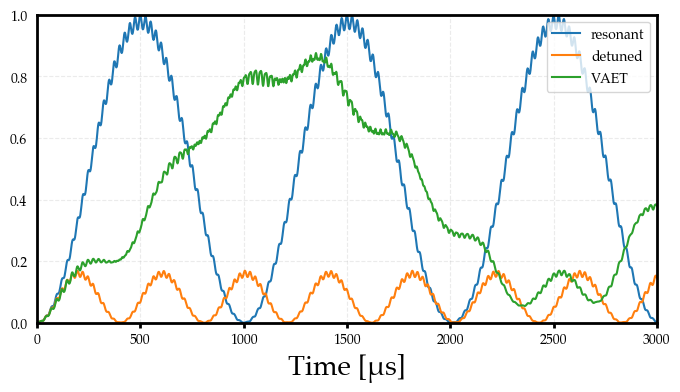

In [18]:
SD_vaet = expect(ionprojector(T, "S-1/2", "D-1/2"), sol_vaet)
step = 1
plt.plot(tout[1:step:end], SD_res[1:step:end], label="resonant")
plt.plot(tout[1:step:end], SD_det[1:step:end], label="detuned")
plt.plot(tout[1:step:end], SD_vaet[1:step:end], label="VAET")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time [μs]");